# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow.compat.v1 as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2022-12-04 17:21:41.791459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:21:42.147232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 17:21:42.147270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 17:21:42.236603: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 17:21:43.777409: W tensorflow/stream_executor/platform/de

## Definição e transmissão do sinal pelo canal

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(Mod, M, SNR_dB, channel_type)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 44.75173852031923 % for SNR = 15 dB


In [4]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [5]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

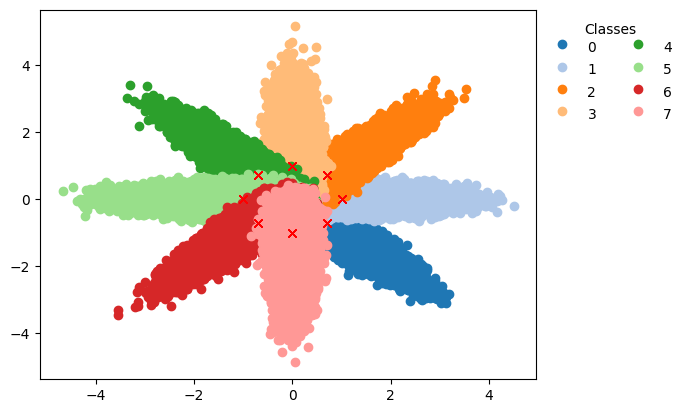

In [6]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [7]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 20
n_hidden2 = 10
n_outputs = M
learning_rate = 0.001
n_epochs = 100
batch_size = 5000

tf.compat.v1.disable_eager_execution()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [8]:
#Função para a criação das camadas ocultas
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        
        if activation is not None:
            return activation(Z)
        else:
            tf.print(Z)
            return Z

In [9]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden1, "hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, "outputs")

In [10]:
with tf.name_scope("loss"):
    tf.print(y)
    tf.print(logits)
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [11]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [12]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
init = tf.global_variables_initializer()

with tf.Session() as s:
    init.run()
    
    print(np.shape(logits.eval(feed_dict={X: X_train})))
    print(np.shape(y_train))
    print(y_train)

2022-12-04 17:21:52.978744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 17:21:52.978813: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 17:21:52.978861: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-popos): /proc/driver/nvidia/version does not exist
2022-12-04 17:21:52.979583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:21:52.984750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization

(500000, 8)
(500000,)
[3 1 4 ... 7 4 4]


In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for interation in range(np.shape(X_train)[0] // batch_size):
            X_batch = X_train[(interation*batch_size):(batch_size*(interation+1))]
            y_batch = y_train[(interation*batch_size):(batch_size*(interation+1))]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
    acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print(acc_val)
    print(f'A taxa de erro simbólica obtida foi de {(1 - acc_val):.2%}')

0 Train accuracy: 0.141 Val accuracy: 0.142328
1 Train accuracy: 0.1658 Val accuracy: 0.168354
2 Train accuracy: 0.287 Val accuracy: 0.284026
3 Train accuracy: 0.3592 Val accuracy: 0.361082
4 Train accuracy: 0.3774 Val accuracy: 0.379198
5 Train accuracy: 0.3854 Val accuracy: 0.3875
6 Train accuracy: 0.404 Val accuracy: 0.409428
7 Train accuracy: 0.419 Val accuracy: 0.42442
8 Train accuracy: 0.4306 Val accuracy: 0.437448
9 Train accuracy: 0.4418 Val accuracy: 0.45096
10 Train accuracy: 0.4576 Val accuracy: 0.465282
11 Train accuracy: 0.473 Val accuracy: 0.480218
12 Train accuracy: 0.4868 Val accuracy: 0.494764
13 Train accuracy: 0.4982 Val accuracy: 0.50735
14 Train accuracy: 0.5082 Val accuracy: 0.518484
15 Train accuracy: 0.517 Val accuracy: 0.528418
16 Train accuracy: 0.5258 Val accuracy: 0.537022
17 Train accuracy: 0.5334 Val accuracy: 0.544076
18 Train accuracy: 0.539 Val accuracy: 0.549932
19 Train accuracy: 0.5442 Val accuracy: 0.554918
20 Train accuracy: 0.5482 Val accuracy: 0.